# Results of running the modified samSpeedComp script, on config2

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
import pandas as pd 
import sys
%matplotlib inline
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + mpl.__version__)

Python version 3.7.2 (default, Jan  3 2019, 09:14:01) 
[GCC 8.2.1 20181215 (Red Hat 8.2.1-6)]
Pandas version 0.24.0
Matplotlib version 3.0.2


# Output file overview:

In [4]:
filepath = 'output_config2.csv'
df = pd.read_csv(filepath)
df['strategy'] = df['strategy'].map(lambda name : name.split('.')[1].lower())
df['sample'] = df['sample'].map(lambda name : name.split('.')[0])
df.head()

,sample,hardware_type,file_system,strategy,split_time,merge_time,split_nb_seeks,merge_nb_seeks,split_read_time,merge_read_time,split_write_time,merge_write_time,split_seek_time,merge_seek_time
0,bigBrainSample1-0-0,ram,tmpfs,multiple,19.824615,22.493328,3,2806,2.002234,10.891019,13.128618,3.664678,0,0.011331
1,bigBrainSample1-0-0,hdd,ext4,clustered,126.160497,133.058816,2808,2806,66.021195,42.563630,59.998115,81.654337,0,0.017618
2,bigBrainSample1-0-0,ram,tmpfs,naive,56.723534,40.653708,8,3388006,17.244015,2.768173,39.407510,2.865144,0,7.750268
3,bigBrainSample0-0-0,ram,tmpfs,clustered,16.675726,20.791382,2808,2806,3.408970,9.640471,13.089564,3.749887,0,0.011175
4,bigBrainSample0-0-1,hdd,ext4,multiple,126.442074,144.761417,3,2806,48.243311,55.932791,73.563009,80.855036,0,0.017451


# Comparison of strategies results 

## Notes
Naive strategy:  
-TMPFS: split time > merge time  
-HDD: split time < merge time  

Splitting times:   
-TMPFS: clustered < multiple   
-HDD: clustered ~= multiple    

Merging times:    
-TMPFS: clustered > multiple   
-HDD: clustered < multiple  

Total times:    
-TMPFS: clustered < multiple   
-HDD: clustered < multiple  

strategies comparison for tmpfs:

            split_time  merge_time  total_time
strategy                                     
clustered   16.152242   21.263619   37.415861
multiple    19.347611   20.372484   39.720095 


strategies comparison for hdd:

            split_time  merge_time  total_time
strategy                                     
clustered  126.435736  131.837318  258.273054
multiple   126.612218  144.706644  271.318862 




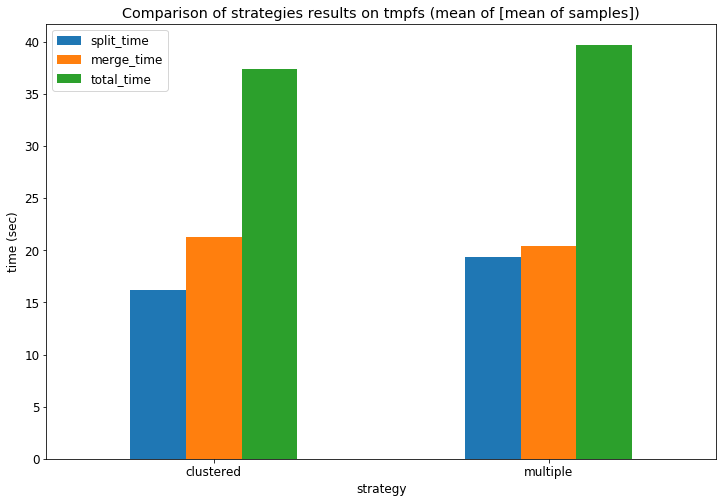

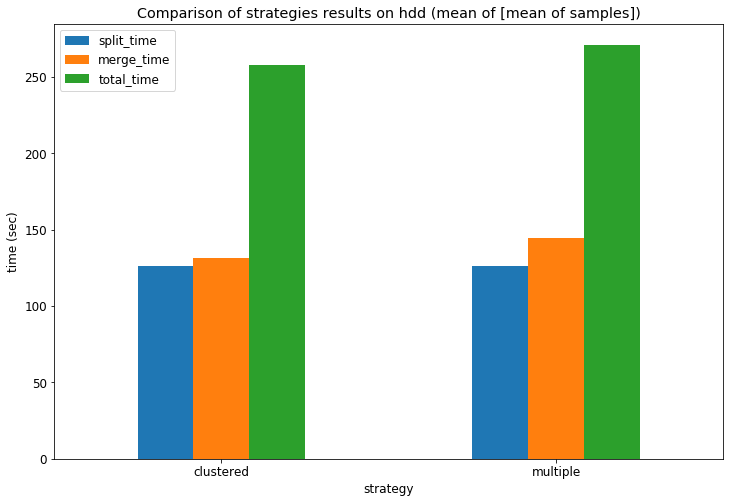

In [82]:
def strategies_comp(tmp, fs_name):
    tmp = tmp.loc[:,:'merge_time']
    tmp = tmp[tmp['strategy'] != 'naive']
    tmp['total_time'] = tmp['split_time'] + tmp['merge_time']
    tmp = tmp.groupby('strategy').mean()
    axes=tmp.plot.bar(title='Comparison of strategies results on ' + fs_name + ' (mean of [mean of samples])')
    axes.set_xticklabels(tmp.index, rotation=0)
    axes.set_ylabel("time (sec)")
    print('strategies comparison for ' + fs_name + ':\n\n', tmp, '\n\n')
    
tmpfs=df[df.file_system == 'tmpfs']
strategies_comp(tmpfs, 'tmpfs')
hdd=df[df.file_system == 'ext4']
strategies_comp(hdd, 'hdd')

# Reading and writing analysis


Mean of the non IO time for split on tmpfs:

            split_time  IO_time_split  non_IO_time
strategy                                         
clustered   16.152242      15.989901     0.162341
multiple    19.347611      14.638617     4.708994
naive       73.793953      73.727143     0.066810

Mean of the non IO time for merge on tmpfs:

            split_time  IO_time_split  non_IO_time
strategy                                         
clustered   16.152242      15.989901     7.767236
multiple    19.347611      14.638617     7.341217
naive       73.793953      73.727143    36.207327

Mean of the non IO time for split on hdd:

            split_time  IO_time_split  non_IO_time
strategy                                         
clustered  126.435736     126.309477     0.126260
multiple   126.612218     122.029921     4.582297
naive      142.700340     142.635513     0.064827

Mean of the non IO time for merge on hdd:

            split_time  IO_time_split  non_IO_time
strategy        

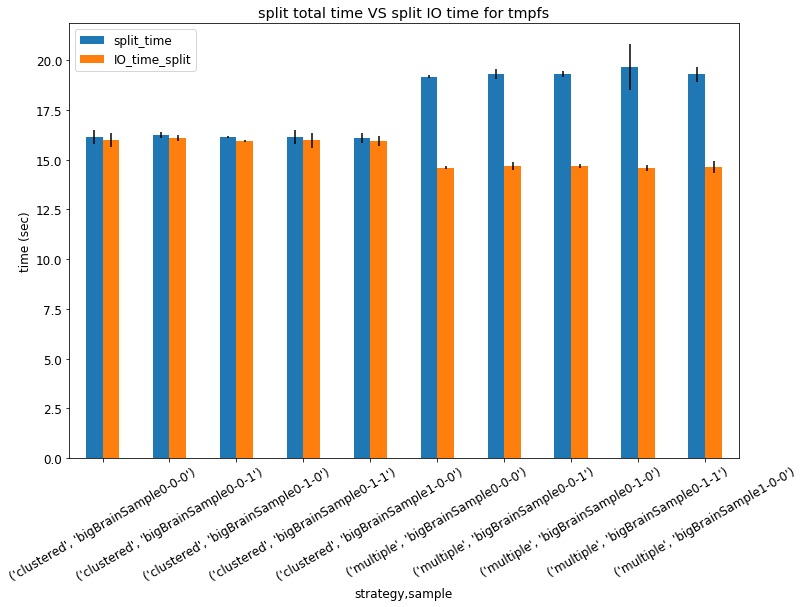

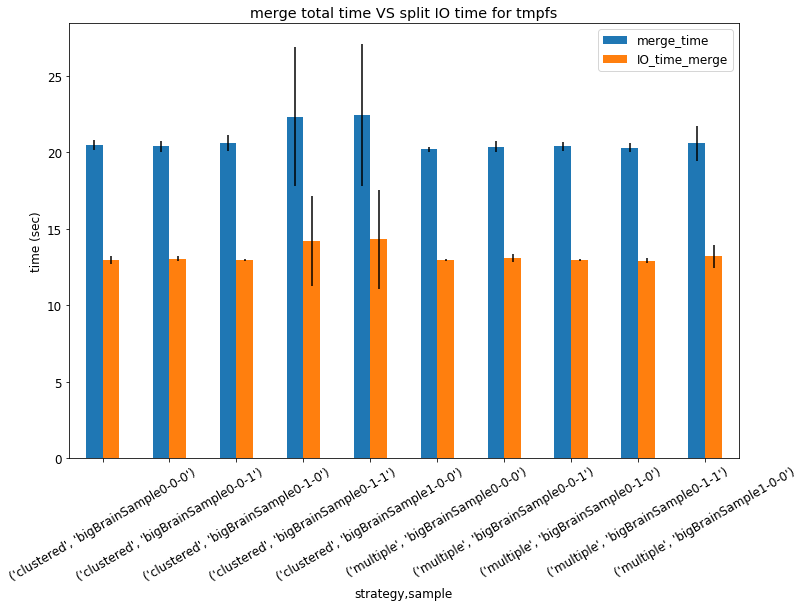

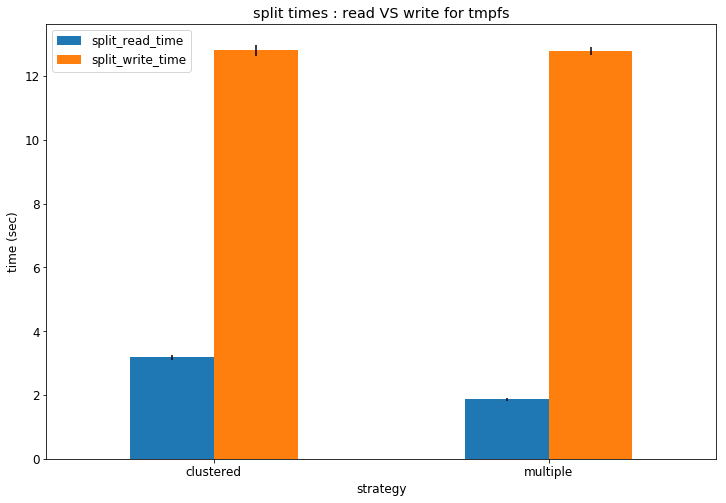

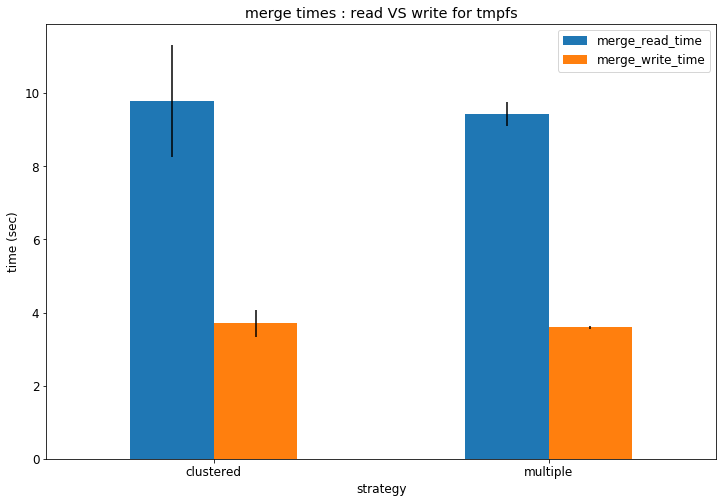

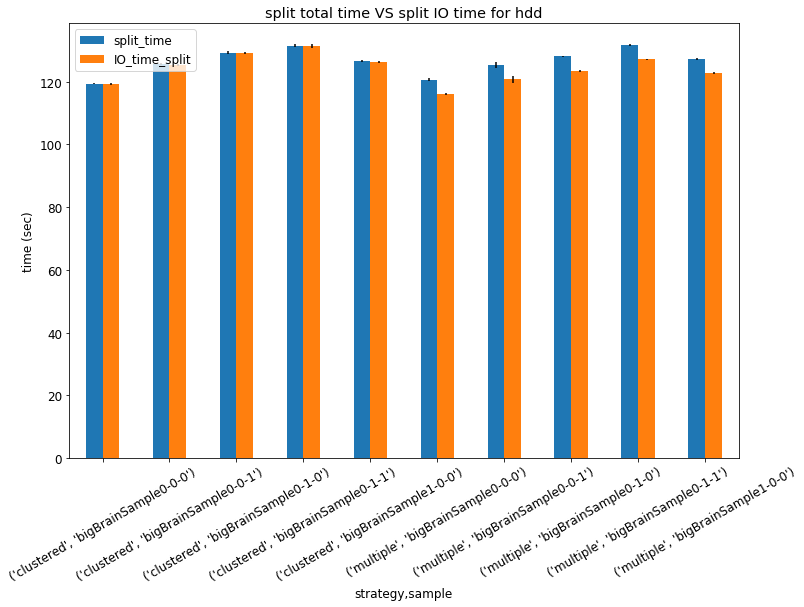

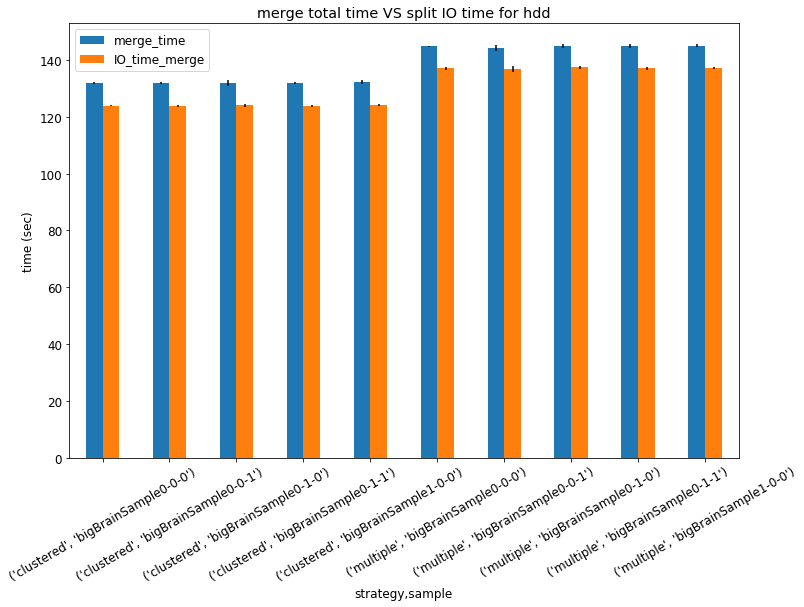

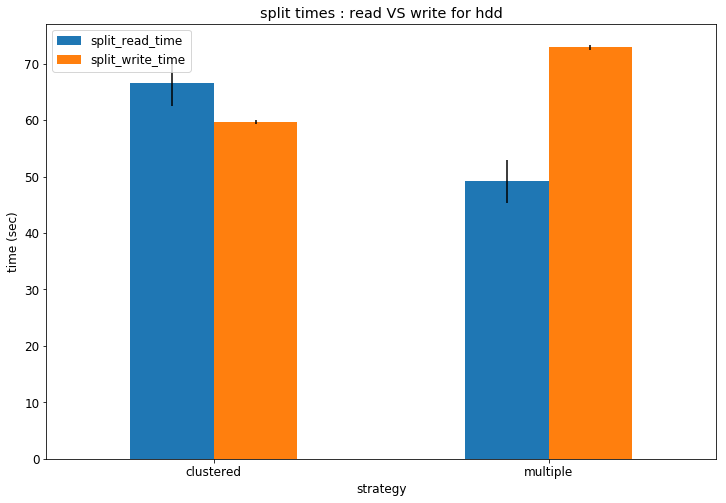

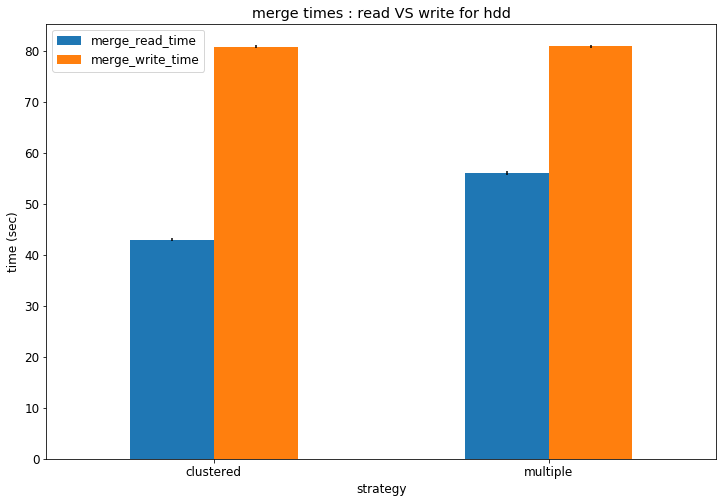

In [72]:
tmpfs=df[df.file_system == 'tmpfs']
hdd=df[df.file_system == 'ext4']

def set_axes(data, axes, rot):
    axes.set_xticklabels(data.index, rotation=rot)
    axes.set_ylabel("time (sec)")

def read_write_sum(data, fstype, time_type):
    rejected = 'split'
    if time_type == 'split':
        rejected='merge'
    data_typed = data[[c for c in data.columns if rejected not in c]]
    group_typed=data_typed.iloc[:,[0,1,2,5]][data_typed['strategy'] != 'naive'].groupby(['strategy','sample'])
    mean_typed = group_typed.mean()
    std_typed = group_typed.std()

    ax1=mean_typed.plot(kind='bar',yerr=std_typed, title=time_type + ' total time VS split IO time for ' + fstype)
    set_axes(mean_typed,ax1, 30)
    
def reads_vs_writes(data, fstype, time_type):
    rejected = 'split'
    if time_type == 'split':
        rejected='merge'
        
    data_wr_typed = data[[c for c in data.columns if rejected not in c]].iloc[:,[0,1,3,4]]
    grp_wr_typed = data_wr_typed[data_wr_typed['strategy'] != 'naive'].groupby(['strategy'])
    grp_wr_typed_mean = grp_wr_typed.mean()
    grp_wr_typed_std = grp_wr_typed.std()

    ax2=grp_wr_typed_mean.plot(kind='bar',yerr=grp_wr_typed_std, title=time_type + ' times : read VS write for ' + fstype)
    set_axes(grp_wr_typed_mean,ax2, 0)

def non_IO(data, fstype, time_type):
    total_time = 2
    IO_time = 8
    
    if time_type == 'merge_time':
        total_time = 3
        IO_time = 9
        
    grp_non_IO = data.iloc[:,[0,1,total_time, IO_time,10]].groupby(['strategy'])
    grp_non_IO_mean = grp_non_IO.mean()
    grp_non_IO_std = grp_non_IO.std()
    print('\nMean of the non IO time for ' + time_type + ' on ' + fstype + ':\n\n', grp_non_IO_mean)
    
def read_write(data, fstype):
    data=data.iloc[:,[0,3,4,5,8,9,10,11]]
    
    data.loc[:,'IO_time_split'] = data['split_read_time'] + data['split_write_time']
    data.loc[:,'IO_time_merge'] = data['merge_read_time'] + data['merge_write_time']
    
    read_write_sum(data, fstype, 'split')
    read_write_sum(data, fstype, 'merge')
    
    reads_vs_writes(data, fstype, 'split')
    reads_vs_writes(data, fstype, 'merge')
    
    data.loc[:,'non_IO_time'] = data['split_time'] - data['IO_time_split']
    non_IO(data, fstype, 'split')
    data.loc[:,'non_IO_time'] = data['merge_time'] - data['IO_time_merge']
    non_IO(data, fstype, 'merge')
    
    
read_write(tmpfs, 'tmpfs')
read_write(hdd, 'hdd')

# Inter and intra sample variability

                               mean split_time
strategy  sample                              
clustered bigBrainSample0-0-0        16.149808
          bigBrainSample0-0-1        16.253202
          bigBrainSample0-1-0        16.125049
          bigBrainSample0-1-1        16.138574
          bigBrainSample1-0-0        16.094576
multiple  bigBrainSample0-0-0        19.173695
          bigBrainSample0-0-1        19.297296
          bigBrainSample0-1-0        19.316634
          bigBrainSample0-1-1        19.666566
          bigBrainSample1-0-0        19.283865
                               std split_time
strategy  sample                             
clustered bigBrainSample0-0-0        0.343177
          bigBrainSample0-0-1        0.150429
          bigBrainSample0-1-0        0.049710
          bigBrainSample0-1-1        0.373171
          bigBrainSample1-0-0        0.262870
multiple  bigBrainSample0-0-0        0.073899
          bigBrainSample0-0-1        0.262378
          bigBrainSamp

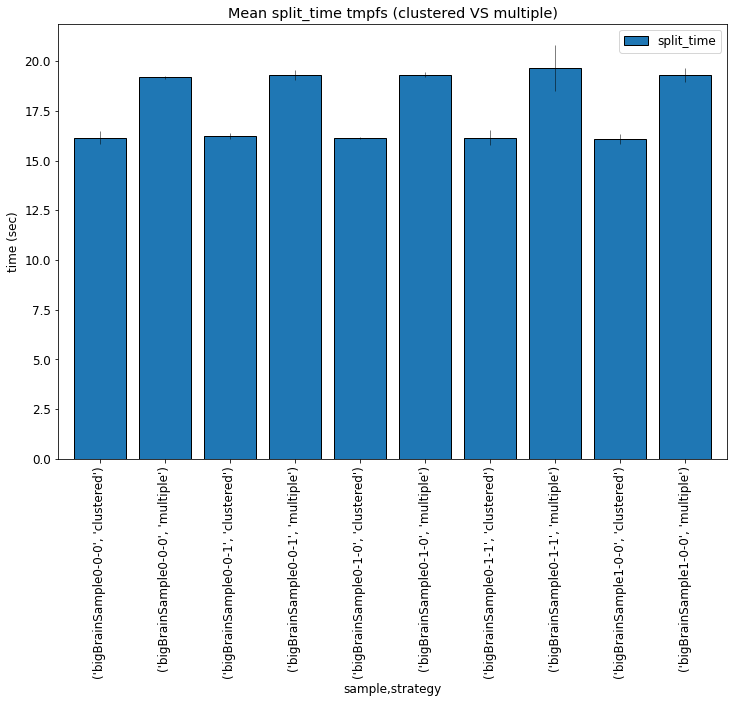

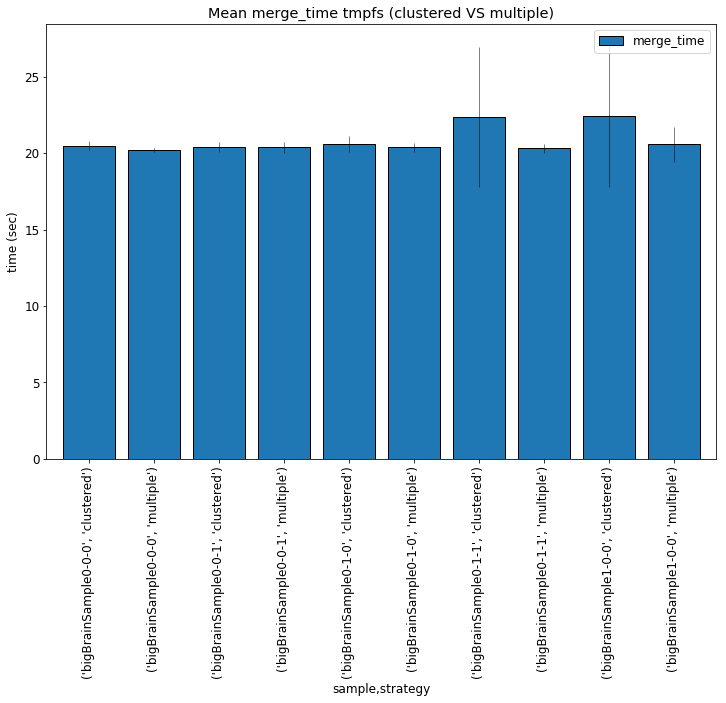

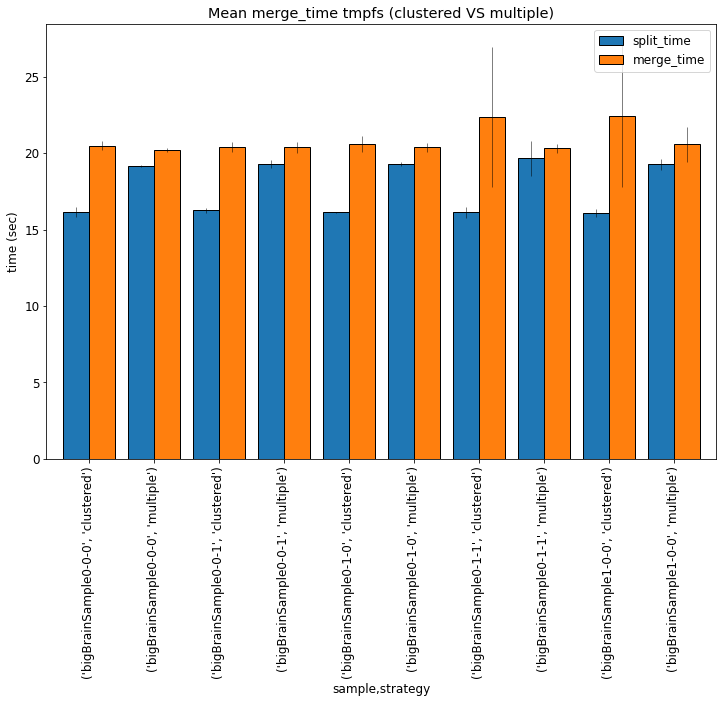

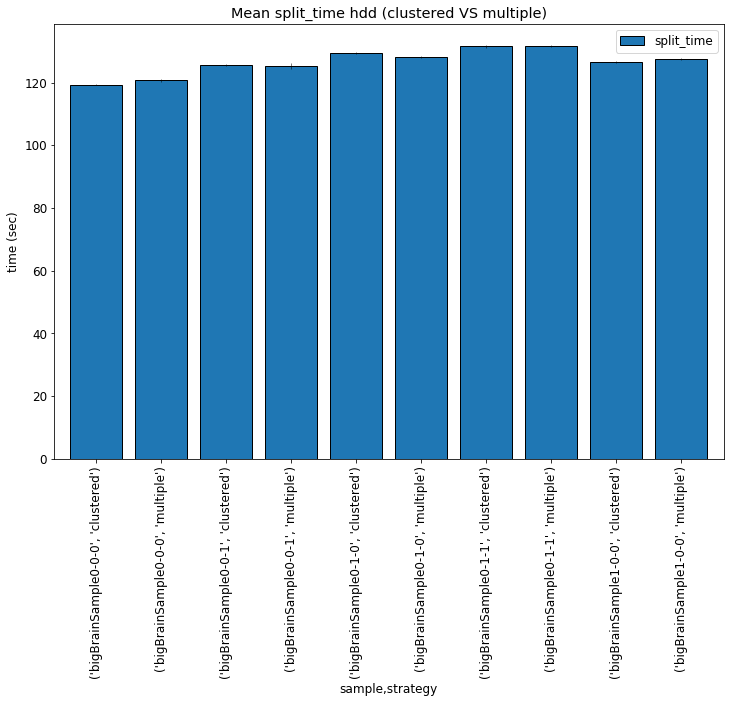

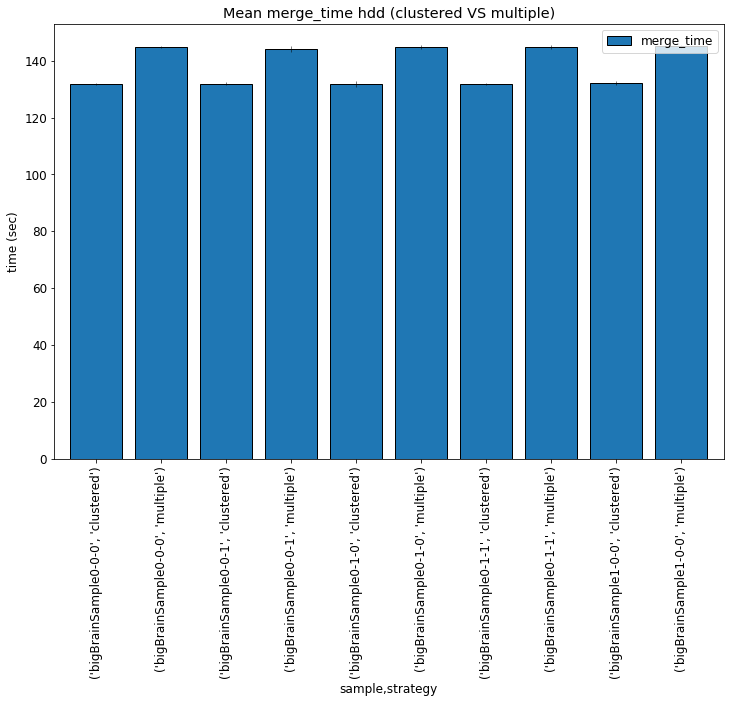

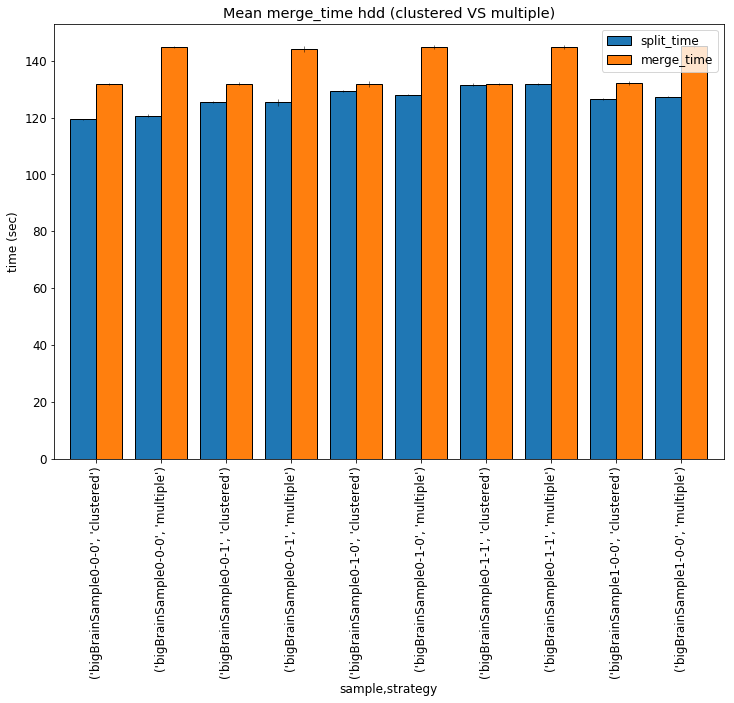

In [80]:
def print_time(data, fs_type, time_type, print_both):
    splits = data[data.strategy != 'naive'].loc[:,:time_type]
    if (time_type=='merge_time') and (not print_both):
        splits=splits.drop('split_time', axis=1)
    
    means=splits.groupby(['sample', 'strategy']).mean()
    std=splits.groupby(['sample', 'strategy']).std()

    ax=means.plot(kind='bar', title='Mean ' + time_type + ' ' + fs_type + ' (clustered VS multiple)',yerr=std,edgecolor='black',error_kw=dict(ecolor='black',elinewidth=0.5),width=0.8)
    ax.set_xticklabels(means.index, rotation=90)
    ax.set_ylabel("time (sec)")
    
    if not print_both:
        splits.rename(columns={time_type:'mean '+ time_type}, inplace=True)
        print(splits.groupby(['strategy', 'sample']).mean())
        splits.rename(columns={'mean '+ time_type:'std '+time_type}, inplace=True)
        print(splits.groupby(['strategy', 'sample']).std())

tmpfs=df[df.file_system == 'tmpfs']
print_time(tmpfs, 'tmpfs', 'split_time', None)
print_time(tmpfs, 'tmpfs', 'merge_time', False)
print_time(tmpfs, 'tmpfs', 'merge_time', True)

hdd=df[df.file_system == 'ext4']
print_time(hdd, 'hdd', 'split_time', None)
print_time(hdd, 'hdd', 'merge_time', False)
print_time(hdd, 'hdd', 'merge_time', True)